In [1]:
import sys
sys.path.append('../code/')

import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm
import pickle

from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import CoxPHFitter

from meningioma_utils import normalize_training_umap

from utils import round_pval

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['hatch.linewidth'] = 5.0 

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = 'Arial'

%matplotlib inline 
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
from meningioma_utils import load_reference_umap
umap_df = load_reference_umap()
umap_df['umap_2'] = -umap_df['umap_2']

In [3]:
metadata_df = pd.read_csv('../data/patient_clinical_metadata.csv', index_col=0)

We are loading precomputed data here. Pretrained UMAPs could be used, but 129,800 UMAPs calls would need to made (One call for each patient (N=1298) for each pretrained UMAP model (N=100)). Loading data for CV is faster for this example.

In [4]:
with open('../data/vst_cv_umap_embeddings.pkl', 'rb') as f:
    cv_umap_embeddings = pickle.load(f)

# Background computation
We are calculating the NNs 129,800 times for cross validation.

In [5]:
from meningioma_centroid_pred_pipeline import stage1_get_nn_bag_dict_new

nn_bag_dict = stage1_get_nn_bag_dict_new(umap_embeddings=cv_umap_embeddings, 
                                         umap_df=umap_df, 
                                         num_nn=100, 
                                         radius=0.05, # input is sqrt of radius
                                         normalize=True,
                                         num_umaps=100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1298/1298 [01:50<00:00, 11.73it/s]


In [6]:
from meningioma_centroid_pred_pipeline import stage2_get_per_common_nn_df

per_common_nn_df = stage2_get_per_common_nn_df(nn_bag_dict=nn_bag_dict, 
                                               umap_df=umap_df, 
                                               num_background_itrs=100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1298/1298 [00:01<00:00, 730.59it/s]


In [7]:
from meningioma_centroid_pred_pipeline import stage3_get_score

score_df, scale_df_dict = stage3_get_score(per_common_nn_df=per_common_nn_df, 
                                           umap_df=umap_df, 
                                           remove_low_freq_nns = True, 
                                           remove_outliers = True, 
                                           remove_radius = True,
                                           mod_prec_thresh = 0.25,
                                           outlier_quantile = 0.95,
                                           radius = 0.75)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1298/1298 [00:07<00:00, 179.76it/s]


In [8]:
SCORE_DF = score_df.loc[(score_df['init_nn_score'] < 0.75)]
print(len(SCORE_DF)/len(score_df))

0.9506933744221879


# Figure 7A

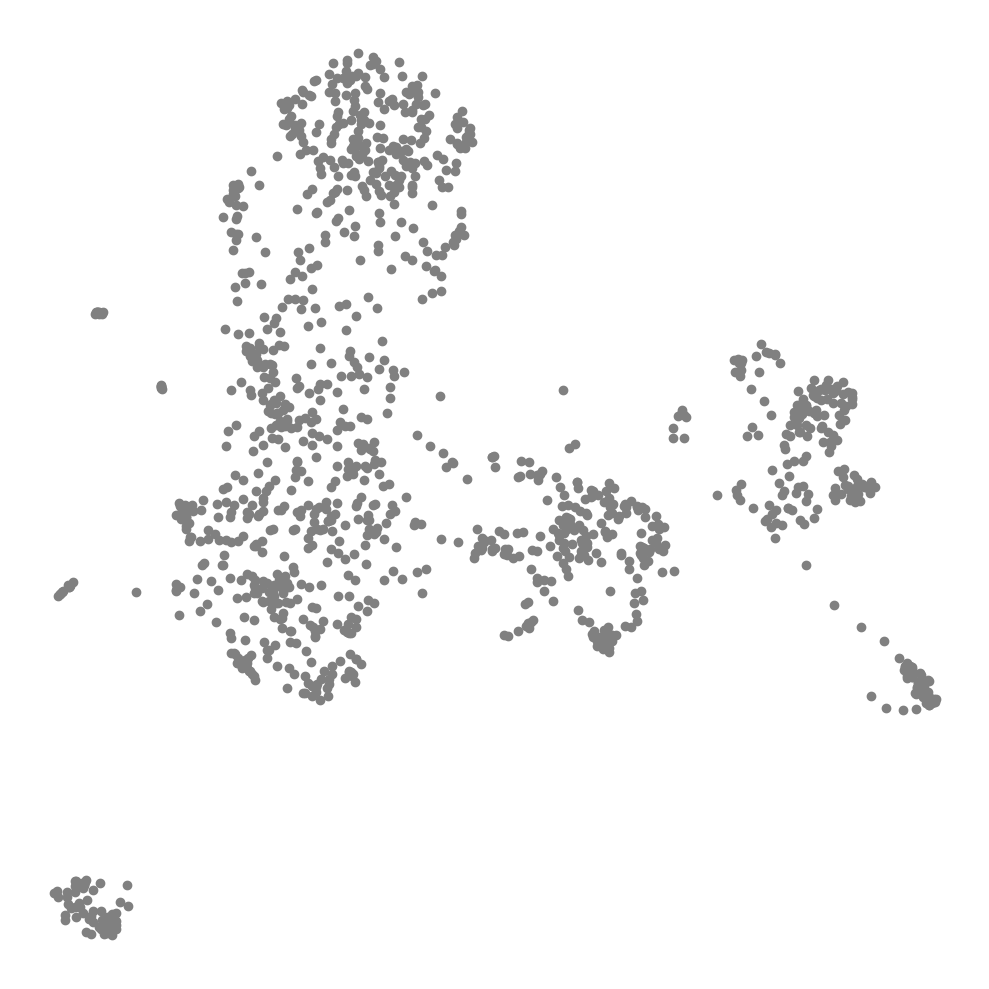

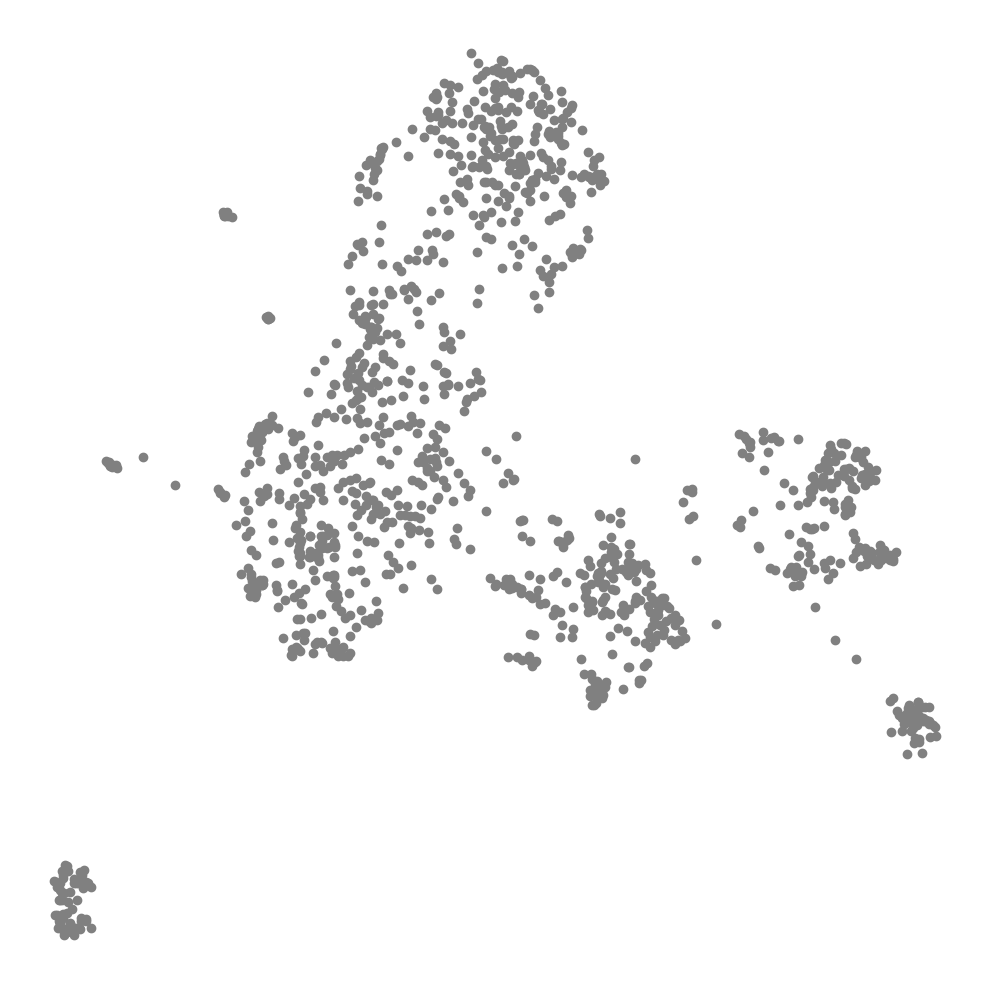

In [9]:
EXAMPLE_PATIENT = 'sample_0'

for rs in [0,5]:
    train_umap_df = cv_umap_embeddings[rs][EXAMPLE_PATIENT]['train_umap_dict']   
    train_umap_df, _, _ = normalize_training_umap(train_umap_df) # center & scale umap embedding

    fig, ax = plt.subplots(figsize=(10,10))

    ax.scatter(train_umap_df['umap_1'], train_umap_df['umap_2'], color='grey')

    ax.spines['right'].set_visible(False) 
    ax.spines['top'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['bottom'].set_visible(False) 

    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# Figure 7B

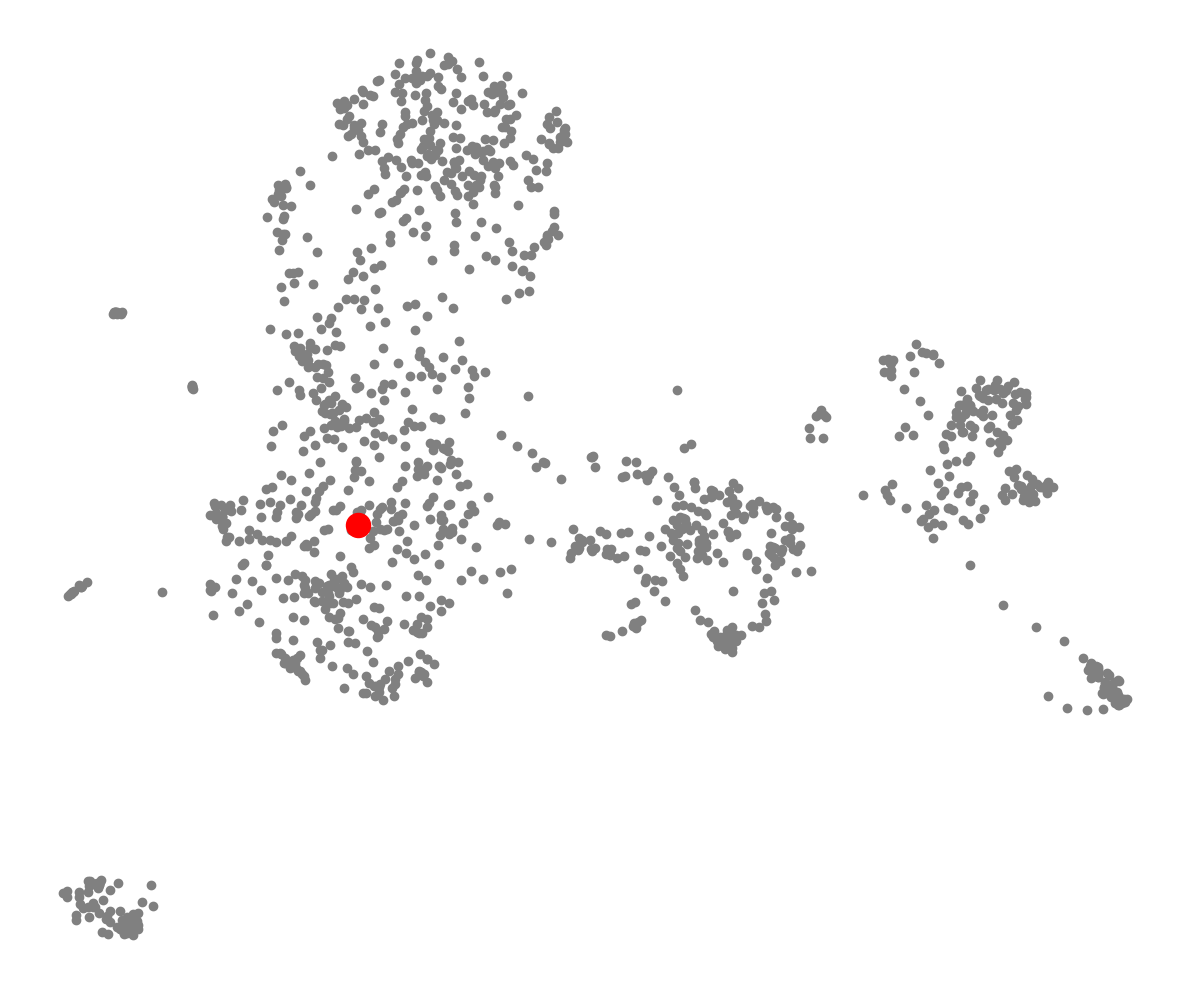

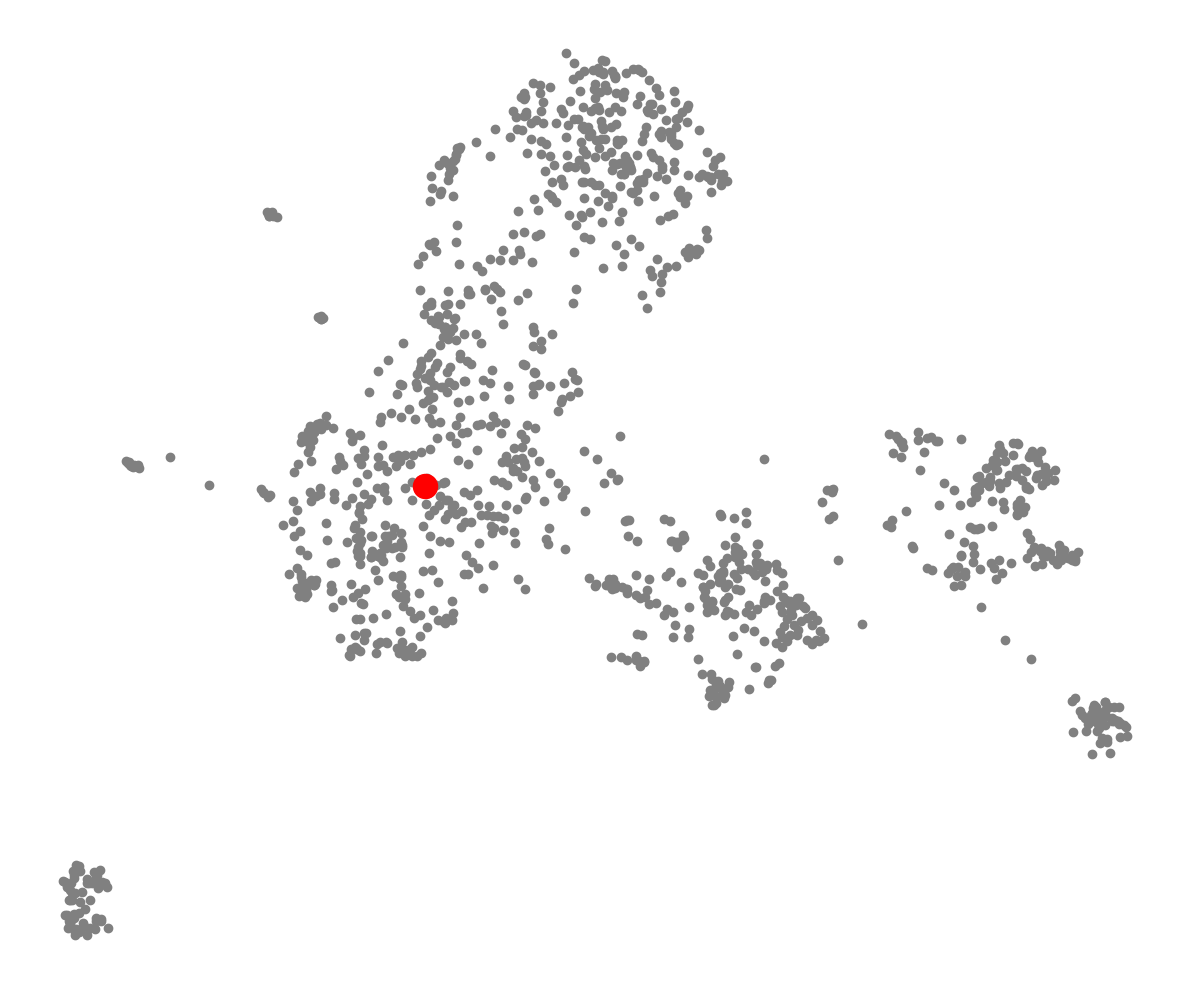

In [10]:
for rs in [0,5]:
    train_umap_df = cv_umap_embeddings[rs][EXAMPLE_PATIENT]['train_umap_dict']
    test_umap_df = cv_umap_embeddings[rs][EXAMPLE_PATIENT]['test_umap_dict']
    
    train_umap_df, mean, dist = normalize_training_umap(train_umap_df)
    test_umap_df = (test_umap_df - mean)/dist


    fig, ax = plt.subplots(figsize=(12,10))

    ax.scatter(train_umap_df['umap_1'], train_umap_df['umap_2'], color='grey')
    ax.scatter(test_umap_df['umap_1'], test_umap_df['umap_2'], color='red', s=300, label='New Patient')

    ax.spines['right'].set_visible(False) 
    ax.spines['top'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['bottom'].set_visible(False) 

    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# Figure 7C
The following axes are slightly rescaled to that the circle appears to be round.

/Users/nuechterleinnk/anaconda3/lib/python3.11/site-packages/matplotlib/transforms.py:2041: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[0, 2] += tx
/Users/nuechterleinnk/anaconda3/lib/python3.11/site-packages/matplotlib/transforms.py:2042: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[1, 2] += ty


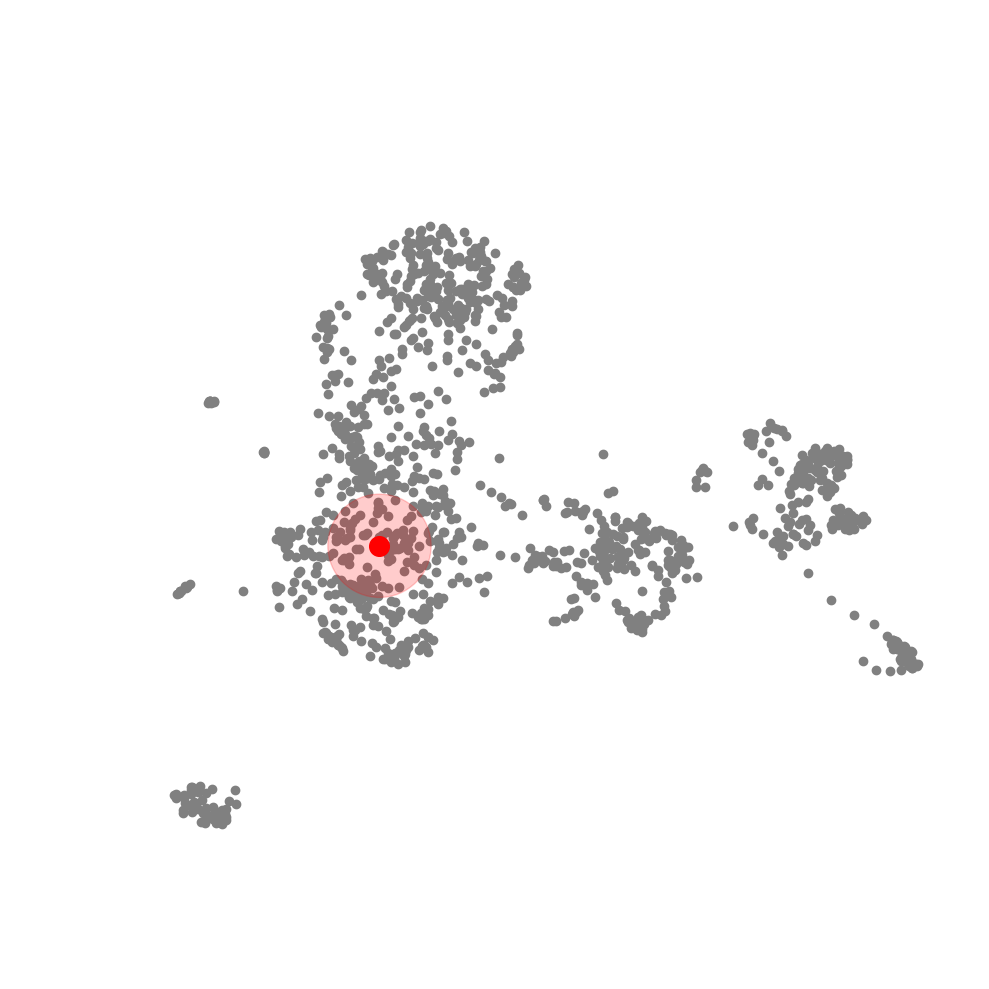

/Users/nuechterleinnk/anaconda3/lib/python3.11/site-packages/matplotlib/transforms.py:2041: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[0, 2] += tx
/Users/nuechterleinnk/anaconda3/lib/python3.11/site-packages/matplotlib/transforms.py:2042: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[1, 2] += ty


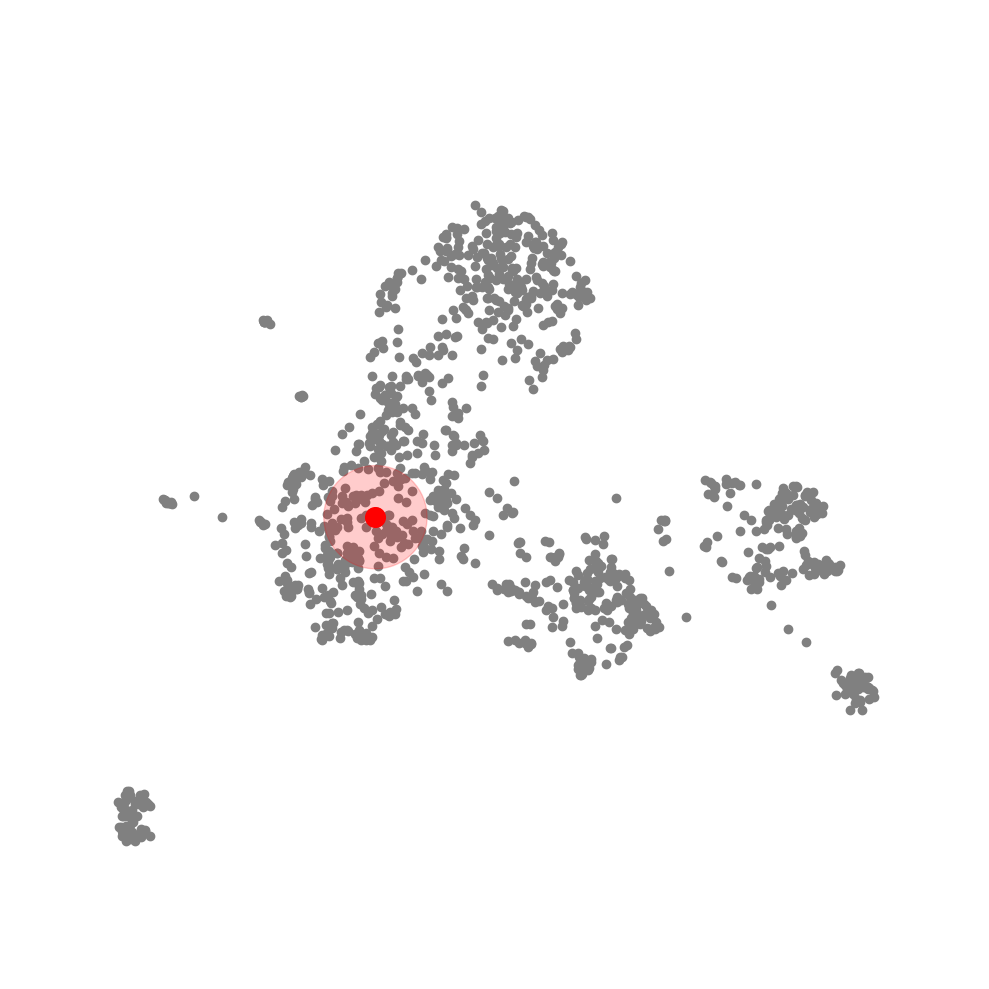

In [11]:
for rs in [0,5]:
    train_umap_df = cv_umap_embeddings[rs][EXAMPLE_PATIENT]['train_umap_dict']
    test_umap_df = cv_umap_embeddings[rs][EXAMPLE_PATIENT]['test_umap_dict']
    
    train_umap_df, mean, dist = normalize_training_umap(train_umap_df)
    test_umap_df = (test_umap_df - mean)/dist


    fig, ax = plt.subplots(figsize=(10,10))

    ax.scatter(train_umap_df['umap_1'], train_umap_df['umap_2'], color='grey')
    ax.scatter(test_umap_df['umap_1'], test_umap_df['umap_2'], color='red', s=200, label='New Patient')
    
    circle = plt.Circle((test_umap_df['umap_1'], test_umap_df['umap_2']), radius=np.sqrt(0.05), color='r', alpha=0.2)
    ax.add_patch(circle)

    ax.spines['right'].set_visible(False) 
    ax.spines['top'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['bottom'].set_visible(False) 

    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlim(-2.1, 2.1)
    ax.set_ylim(-2.1, 2.1)

    plt.tight_layout()
    plt.show()

# Figure 7D

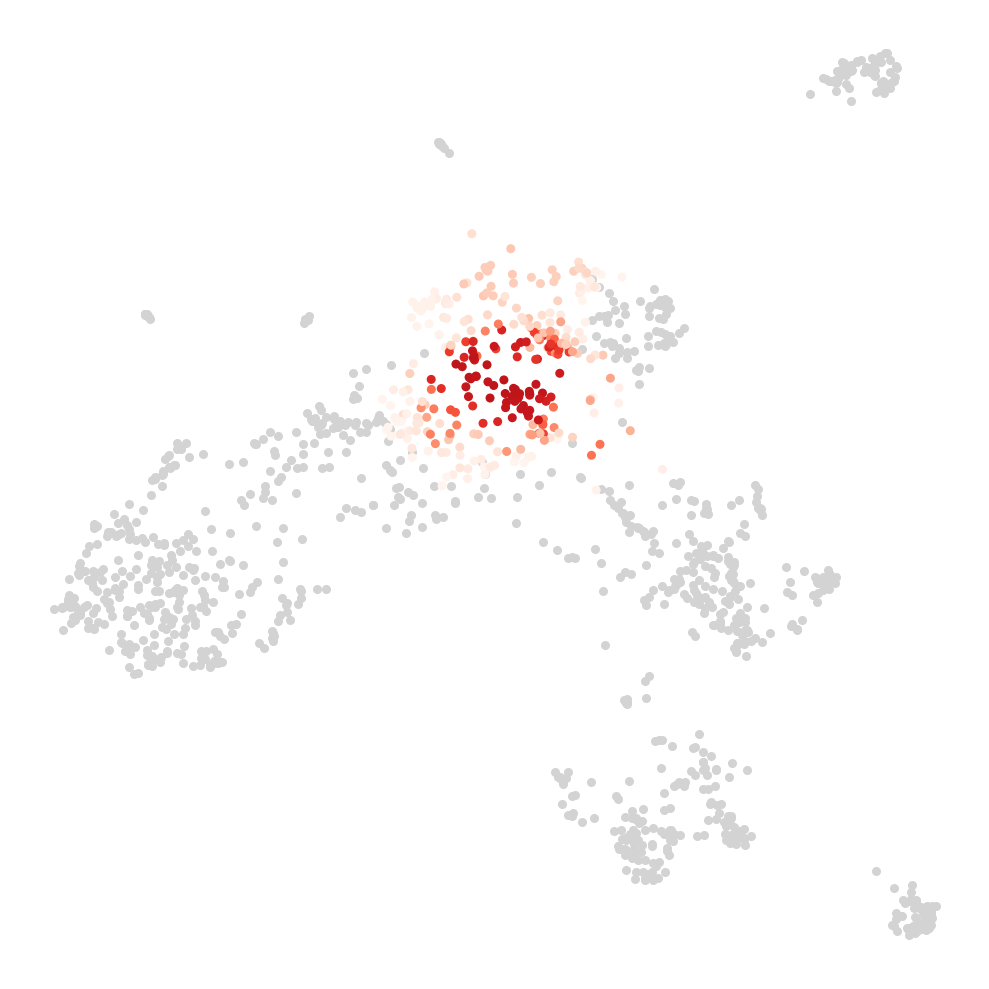

In [12]:
_baseline_scale_df = scale_df_dict[EXAMPLE_PATIENT]['baseline']
_final_scale_df = scale_df_dict[EXAMPLE_PATIENT]['3-radius']

_scale_df = _baseline_scale_df.copy()

fig, ax = plt.subplots(figsize=(10,10))


zero_idxs = _scale_df.loc[_scale_df == 0].index.tolist()
zero_idxs = [x for x in zero_idxs if EXAMPLE_PATIENT != x]

ax.scatter(umap_df.loc[zero_idxs]['umap_1'], 
                umap_df.loc[zero_idxs]['umap_2'], 
                marker='o', 
                color='lightgrey',
                s=30,
                alpha=1)


sc = ax.scatter(umap_df['umap_1'].drop(index=zero_idxs + [EXAMPLE_PATIENT]), 
                     umap_df['umap_2'].drop(index=zero_idxs + [EXAMPLE_PATIENT]), 
                     c=_scale_df.drop(index=zero_idxs + [EXAMPLE_PATIENT]), 
                     cmap='Reds',
                     s=30,
                     vmin=0,
                     vmax=1)

# centroid
temp_umap_df = umap_df.copy()
temp_umap_df['umap_1'] = temp_umap_df['umap_1']*_scale_df
temp_umap_df['umap_2'] = temp_umap_df['umap_2']*_scale_df

ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['bottom'].set_visible(False) 
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

# Figure 7E

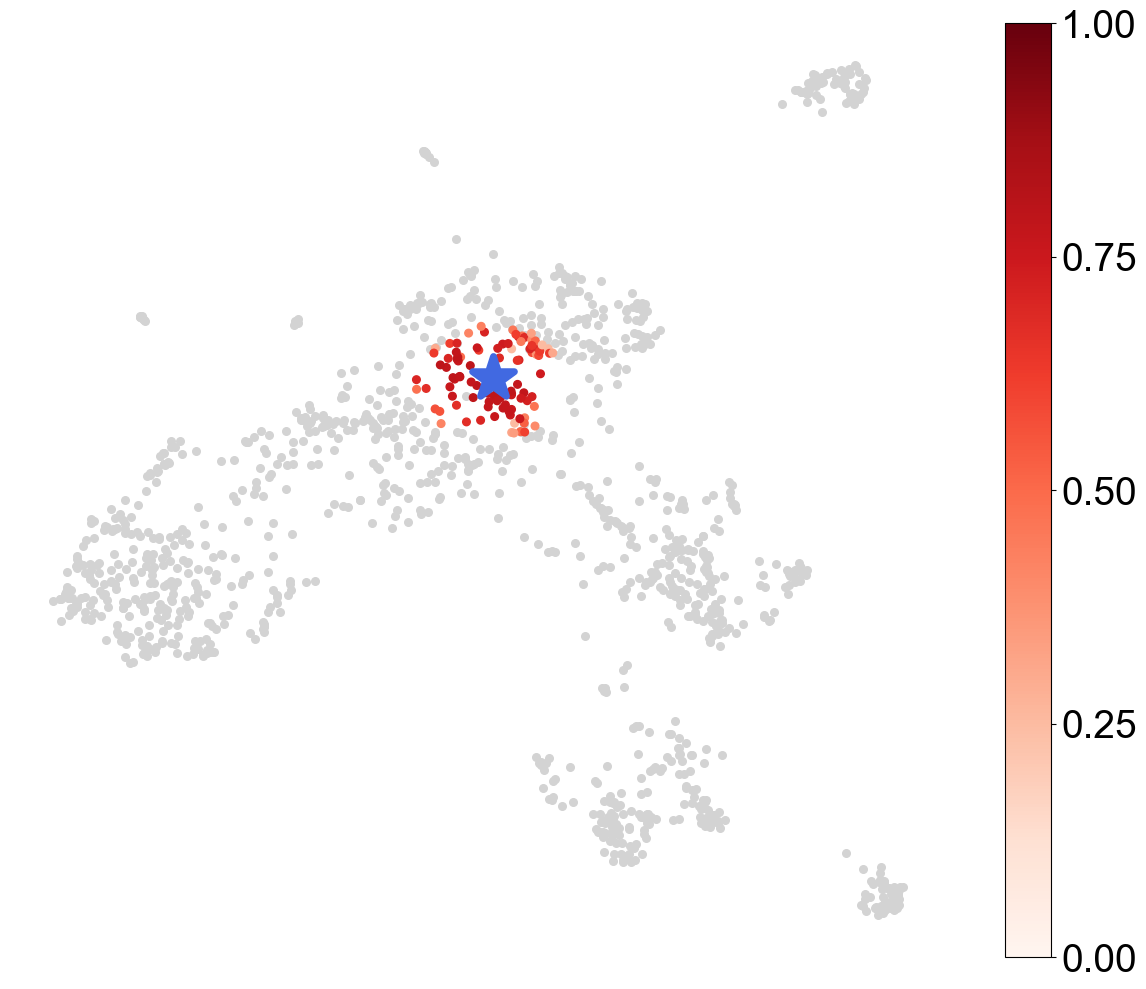

In [13]:
_baseline_scale_df = scale_df_dict[EXAMPLE_PATIENT]['baseline']
_final_scale_df = scale_df_dict[EXAMPLE_PATIENT]['3-radius']

_scale_df = _final_scale_df.copy()

fig, ax = plt.subplots(figsize=(12,10))


zero_idxs = _scale_df.loc[_scale_df == 0].index.tolist()

ax.scatter(umap_df.loc[zero_idxs]['umap_1'], 
                umap_df.loc[zero_idxs]['umap_2'], 
                marker='o', 
                color='lightgrey',
                s=30,
                alpha=1)


sc = ax.scatter(umap_df['umap_1'].drop(index=zero_idxs + [EXAMPLE_PATIENT]), 
                     umap_df['umap_2'].drop(index=zero_idxs + [EXAMPLE_PATIENT]), 
                     c=_scale_df.drop(index=zero_idxs + [EXAMPLE_PATIENT]), 
                     cmap='Reds',
                     s=30,
                     vmin=0,
                     vmax=1)

# centroid
temp_umap_df = umap_df.copy()
temp_umap_df['umap_1'] = temp_umap_df['umap_1']*_scale_df
temp_umap_df['umap_2'] = temp_umap_df['umap_2']*_scale_df

x, y = temp_umap_df.sum()/_scale_df.sum()
ax.scatter(x, y, edgecolors='royalblue', 
           marker='*', 
           s=1000, 
           facecolors='royalblue',
           alpha=1,
          linewidth=5,)

# color bar
cbar = fig.colorbar(sc, ax=ax)
cbar.ax.get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=28)

ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['bottom'].set_visible(False) 

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

# Figure 7F

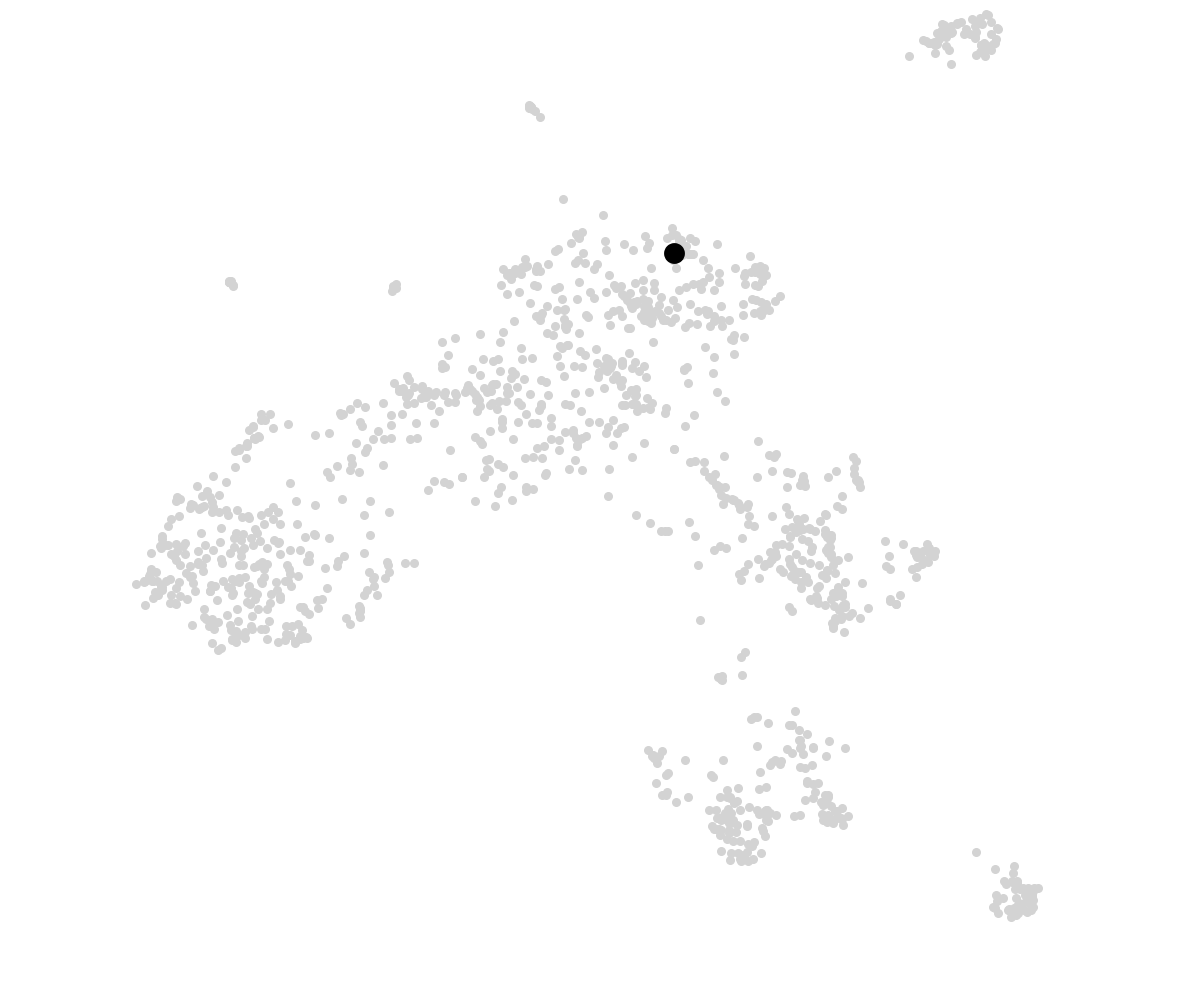

In [14]:
EXAMPLE_PATIENT_7fgh = 'sample_885'

_baseline_scale_df = scale_df_dict[EXAMPLE_PATIENT_7fgh]['baseline']
_final_scale_df = scale_df_dict[EXAMPLE_PATIENT_7fgh]['3-radius']

_scale_df = _baseline_scale_df.copy()

fig, ax = plt.subplots(figsize=(12,10))


zero_idxs = _scale_df.loc[_scale_df == 0].index.tolist()

ax.scatter(umap_df.drop(EXAMPLE_PATIENT_7fgh)['umap_1'], 
                umap_df.drop(EXAMPLE_PATIENT_7fgh)['umap_2'], 
                marker='o', 
                color='lightgrey',
                s=30,
                alpha=1)

ax.scatter(umap_df.loc[EXAMPLE_PATIENT_7fgh]['umap_1'], 
                umap_df.loc[EXAMPLE_PATIENT_7fgh]['umap_2'], 
                marker='o', 
                linewidth=5,
                edgecolors='black',
                facecolors='black', 
                s=100,
                alpha=1)

# centroid
temp_umap_df = umap_df.copy()
temp_umap_df['umap_1'] = temp_umap_df['umap_1']*_scale_df
temp_umap_df['umap_2'] = temp_umap_df['umap_2']*_scale_df

ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['bottom'].set_visible(False) 

ax.set_xticks([])
ax.set_yticks([])

plt.ylim(-6.5, 6.5)
plt.xlim(-6, 6)

plt.tight_layout()
plt.show()

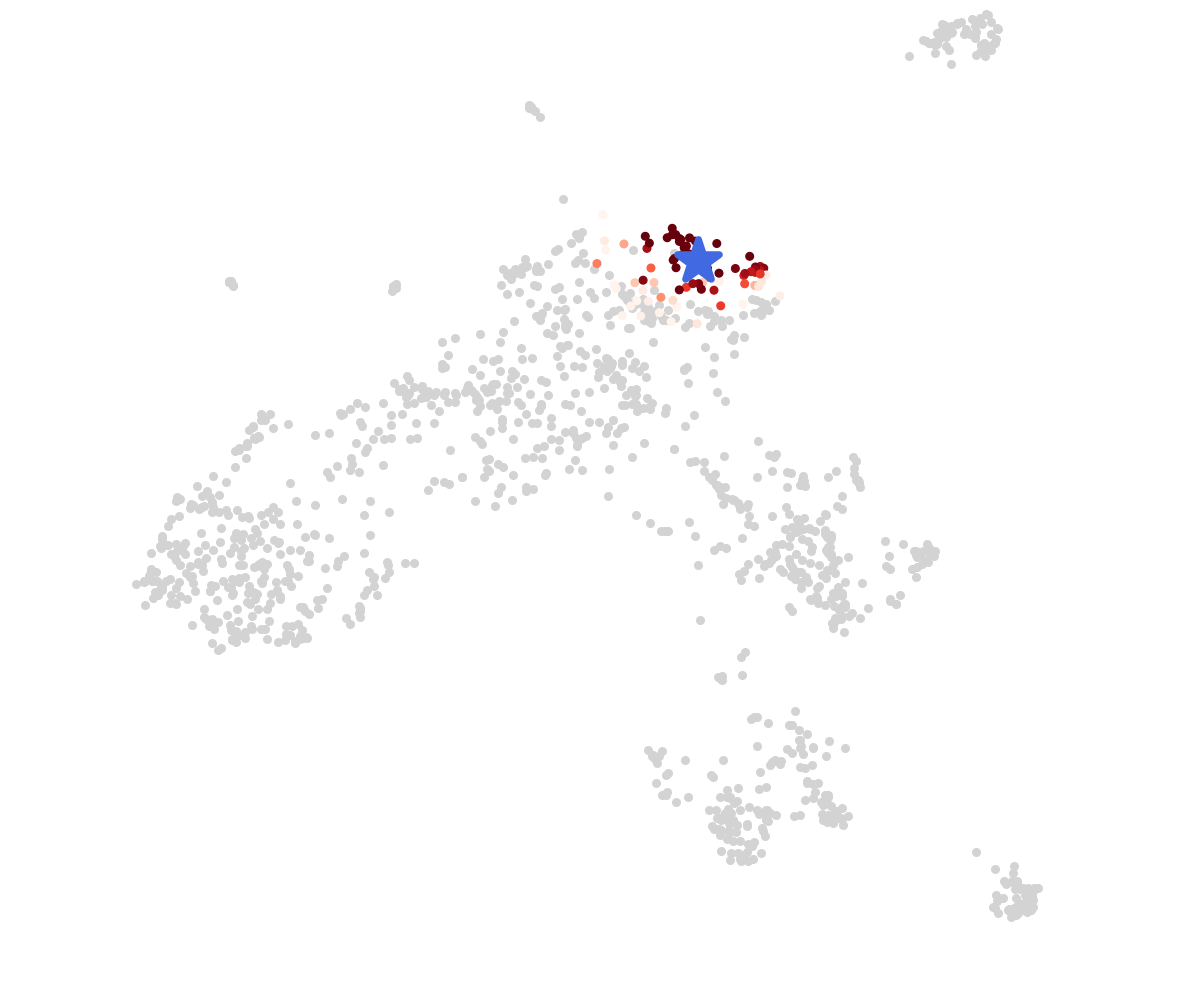

In [15]:
_baseline_scale_df = scale_df_dict[EXAMPLE_PATIENT_7fgh]['baseline']
_final_scale_df = scale_df_dict[EXAMPLE_PATIENT_7fgh]['3-radius']

_scale_df = _baseline_scale_df.copy()

fig, ax = plt.subplots(figsize=(12,10))


zero_idxs = _scale_df.loc[_scale_df == 0].index.tolist()

ax.scatter(umap_df.loc[zero_idxs]['umap_1'], 
                umap_df.loc[zero_idxs]['umap_2'], 
                marker='o', 
                color='lightgrey',
                s=30,
                alpha=1)


sc = ax.scatter(umap_df['umap_1'].drop(index=zero_idxs + [EXAMPLE_PATIENT_7fgh]), 
                     umap_df['umap_2'].drop(index=zero_idxs + [EXAMPLE_PATIENT_7fgh]), 
                     c=_scale_df.drop(index=zero_idxs + [EXAMPLE_PATIENT_7fgh]), 
                     cmap='Reds',
                     s=30,
                     vmin=0,
                     vmax=1)


# centroid
temp_umap_df = umap_df.copy()
temp_umap_df['umap_1'] = temp_umap_df['umap_1']*_scale_df
temp_umap_df['umap_2'] = temp_umap_df['umap_2']*_scale_df

x, y = temp_umap_df.sum()/_scale_df.sum()
ax.scatter(x, y, 
           edgecolors='royalblue', 
           marker='*', 
           s=1000, 
           facecolors='royalblue',
           alpha=1,
           linewidth=5,)

ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['bottom'].set_visible(False) 
ax.set_xticks([])
ax.set_yticks([])

plt.ylim(-6.5, 6.5)
plt.xlim(-6, 6)

plt.tight_layout()
plt.show()

# Figure 7H

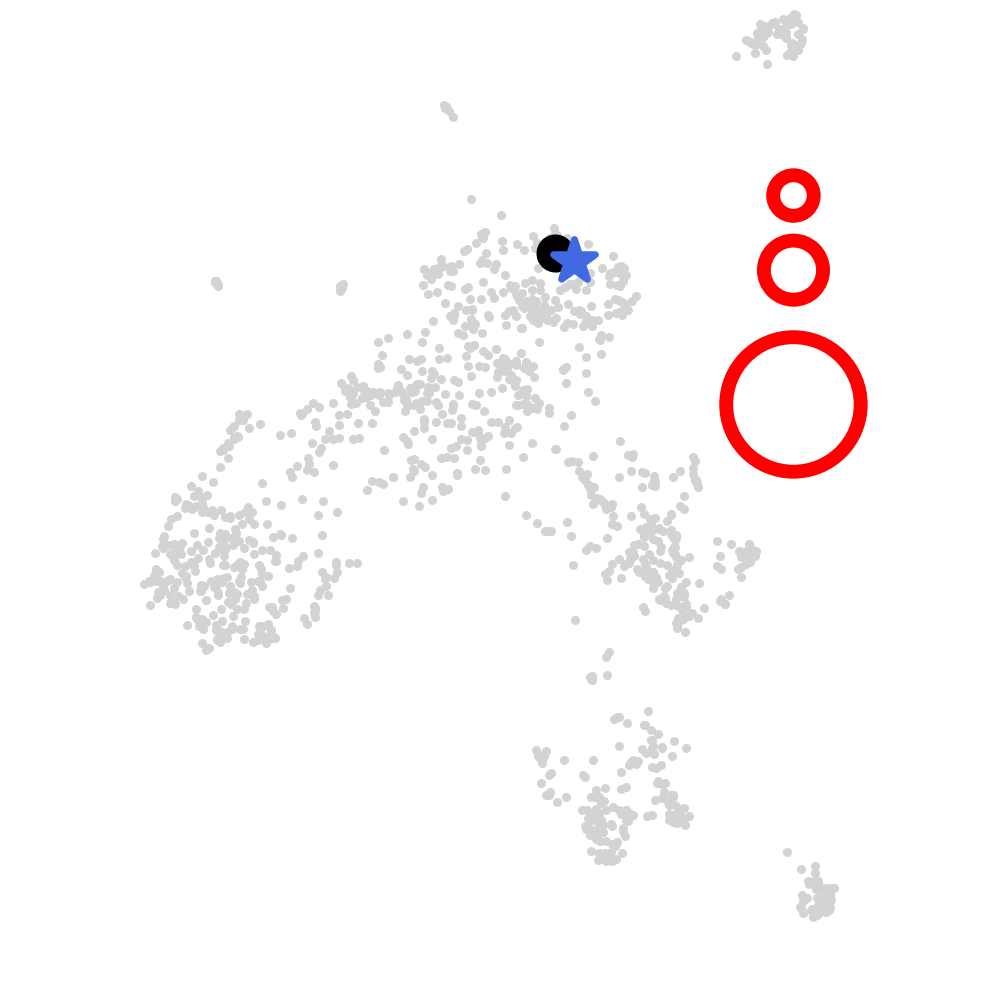

In [16]:
_baseline_scale_df = scale_df_dict[EXAMPLE_PATIENT_7fgh]['baseline']
_scale_df = _baseline_scale_df.copy()

# plot
fig, ax = plt.subplots(figsize=(10,10))

zero_idxs = _scale_df.loc[_scale_df == 0].index.tolist()

ax.scatter(umap_df.drop(EXAMPLE_PATIENT_7fgh)['umap_1'], umap_df.drop(EXAMPLE_PATIENT_7fgh)['umap_2'], marker='o', color='lightgrey',
           s=30, alpha=1)
ax.scatter(umap_df.loc[EXAMPLE_PATIENT_7fgh]['umap_1'], umap_df.loc[EXAMPLE_PATIENT_7fgh]['umap_2'], marker='o', linewidth=5, 
           edgecolors='black', facecolors='black', s=500, alpha=1)

# centroid
temp_umap_df = umap_df.copy()
temp_umap_df['umap_1'] = temp_umap_df['umap_1']*_scale_df
temp_umap_df['umap_2'] = temp_umap_df['umap_2']*_scale_df

x, y = temp_umap_df.sum()/_scale_df.sum()
ax.scatter(x, y, edgecolors='royalblue', marker='*', s=1000, facecolors='royalblue', alpha=1, linewidth=5)

ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['bottom'].set_visible(False) 

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylim(-6.5, 6.5)
ax.set_xlim(-6.5, 6.5)

cc1 = plt.Circle(( 4 , 4), SCORE_DF['cent_dist'].median(), fill=False, edgecolor='red', ls='-', lw=10)
cc2 = plt.Circle(( 4 , 3), SCORE_DF['cent_dist'].quantile(0.75), fill=False, edgecolor='red', ls='-', lw=10)
cc3 = plt.Circle(( 4 , 1.2), SCORE_DF['cent_dist'].quantile(0.95), fill=False, edgecolor='red', ls='-', lw=10)

ax.add_artist(cc1) 
ax.add_artist(cc2) 
ax.add_artist(cc3) 

plt.tight_layout()
plt.show()

# Figure 7I

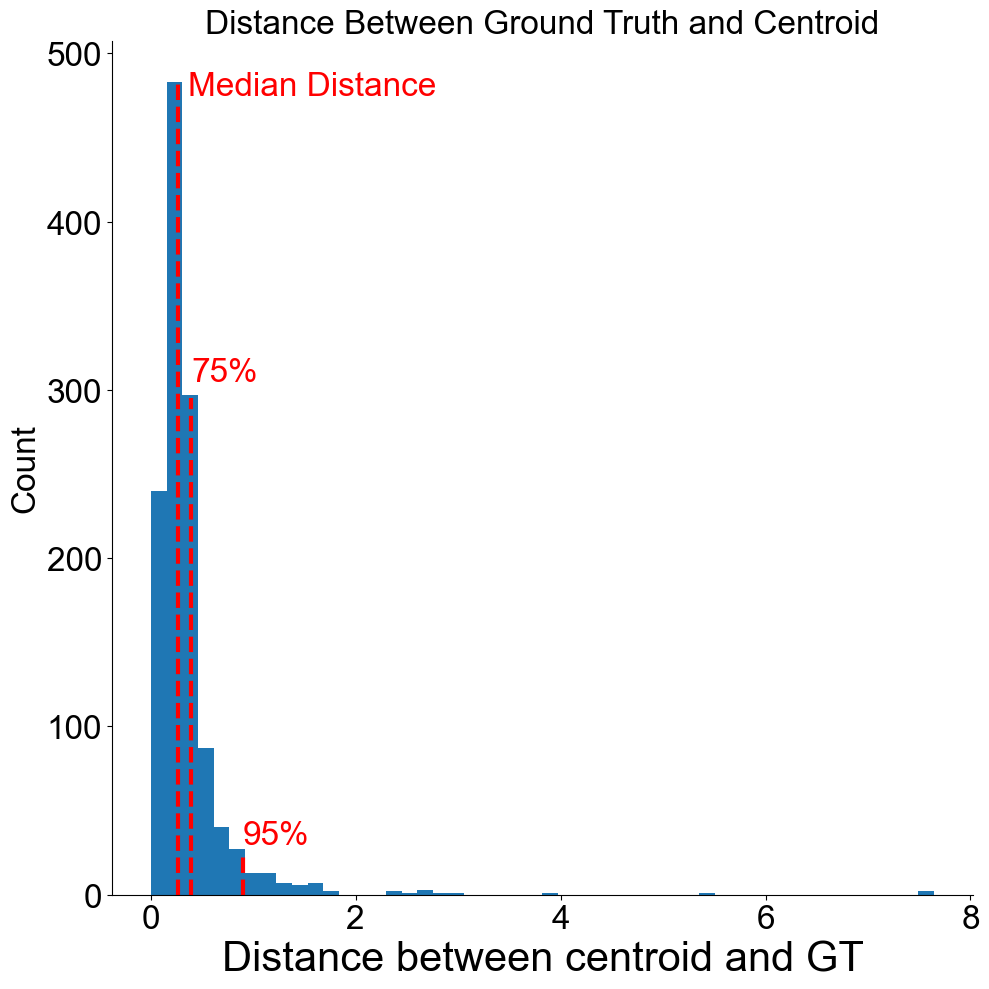

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

ax.hist(SCORE_DF['cent_dist'], bins=50)

ax.plot([SCORE_DF['cent_dist'].median(), SCORE_DF['cent_dist'].median()], [0,483], ls='--', lw=3, color='red')
ax.plot([SCORE_DF['cent_dist'].quantile(0.75), SCORE_DF['cent_dist'].quantile(0.75)], 
        [0,295], 
        ls='--', 
        lw=3, 
        color='red')
ax.plot([SCORE_DF['cent_dist'].quantile(0.95), SCORE_DF['cent_dist'].quantile(0.95)], [0,25], ls='--', lw=3, color='red')

ax.set_ylabel('Count', fontsize=24)
ax.set_xlabel('Distance between centroid and GT', fontsize=30)

ax.tick_params(labelsize=24)

ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 

ax.set_title('Distance Between Ground Truth and Centroid', fontsize=24)

ax.text(x=SCORE_DF['cent_dist'].quantile(0.75), y=305, s='75%', fontsize=24, color='red')
ax.text(x=SCORE_DF['cent_dist'].quantile(0.95), y=30, s='95%', fontsize=24, color='red')
ax.text(x=0.37, y=475, s='Median Distance', fontsize=24, color='red')

plt.tight_layout()

# Figure 7J

In [18]:
grade_radius = 1
metadata_col = 'WHO_GRADE'

weight_list = [40]

vc_df_list = []
na_idxs = metadata_df.loc[metadata_df[metadata_col] == 'na'].index.tolist()

for patient in tqdm(SCORE_DF.index):
    x_cent, y_cent = SCORE_DF.loc[patient]['x_cent'], SCORE_DF.loc[patient]['y_cent']
    
    values = np.sum((umap_df - np.array([x_cent, y_cent]))**2, axis=1)
    dist_df = pd.DataFrame(data=values, 
                           index=umap_df.index, 
                           columns=['dist']).drop(index=[patient]).sort_values('dist')
    dist_df = dist_df.loc[~dist_df.index.isin(na_idxs)]
    dist_df = dist_df.loc[dist_df['dist'] < grade_radius]
    
    _vc_df_list = []
    for num_nn in weight_list:
        
        nns_idxs = dist_df.index.tolist()[:num_nn]
        vc_df = metadata_df.loc[nns_idxs][metadata_col].value_counts()
        vc_df.name = patient
        _vc_df_list.append(vc_df)
        
    vc_merged_df = pd.concat(_vc_df_list)
    vc_merged_df = vc_merged_df.groupby(vc_merged_df.index).sum()
    vc_df_list.append(vc_merged_df)
    
grade_weight_df = pd.concat(vc_df_list, axis=1).replace({np.nan:0})/np.sum(weight_list)
who_grade_pred_df = grade_weight_df.idxmax(axis=0)

  0%|          | 0/1234 [00:00<?, ?it/s]

In [19]:
pred_gt_df = pd.concat([metadata_df['WHO_GRADE'], who_grade_pred_df], axis=1, join='inner')
pred_gt_df = pred_gt_df.rename(columns={'WHO_GRADE':'GT_WHO_Grade', 0:'Pred_WHO_Grade'})
pred_gt_df = pred_gt_df.loc[pred_gt_df['GT_WHO_Grade'] != 'na']
pred_gt_df = pred_gt_df.sort_values('GT_WHO_Grade')

/var/folders/bn/gp8lnmqn7h585rt7v2n467jnfnys2f/T/ipykernel_96160/1419335009.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cph.fit(kmf_temp_df.replace(replace_dict), duration_col='RFS', event_col="RFS_EVENT")
/var/folders/bn/gp8lnmqn7h585rt7v2n467jnfnys2f/T/ipykernel_96160/1419335009.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cph.fit(kmf_temp_df.replace(replace_dict), duration_col='RFS', event_col="RFS_EVENT")
/var/folders/bn/gp8lnmqn7h585rt7v2n467jnfnys2f/T/ipykernel_96160/1419335009.py:41: FutureWarning: Downcast

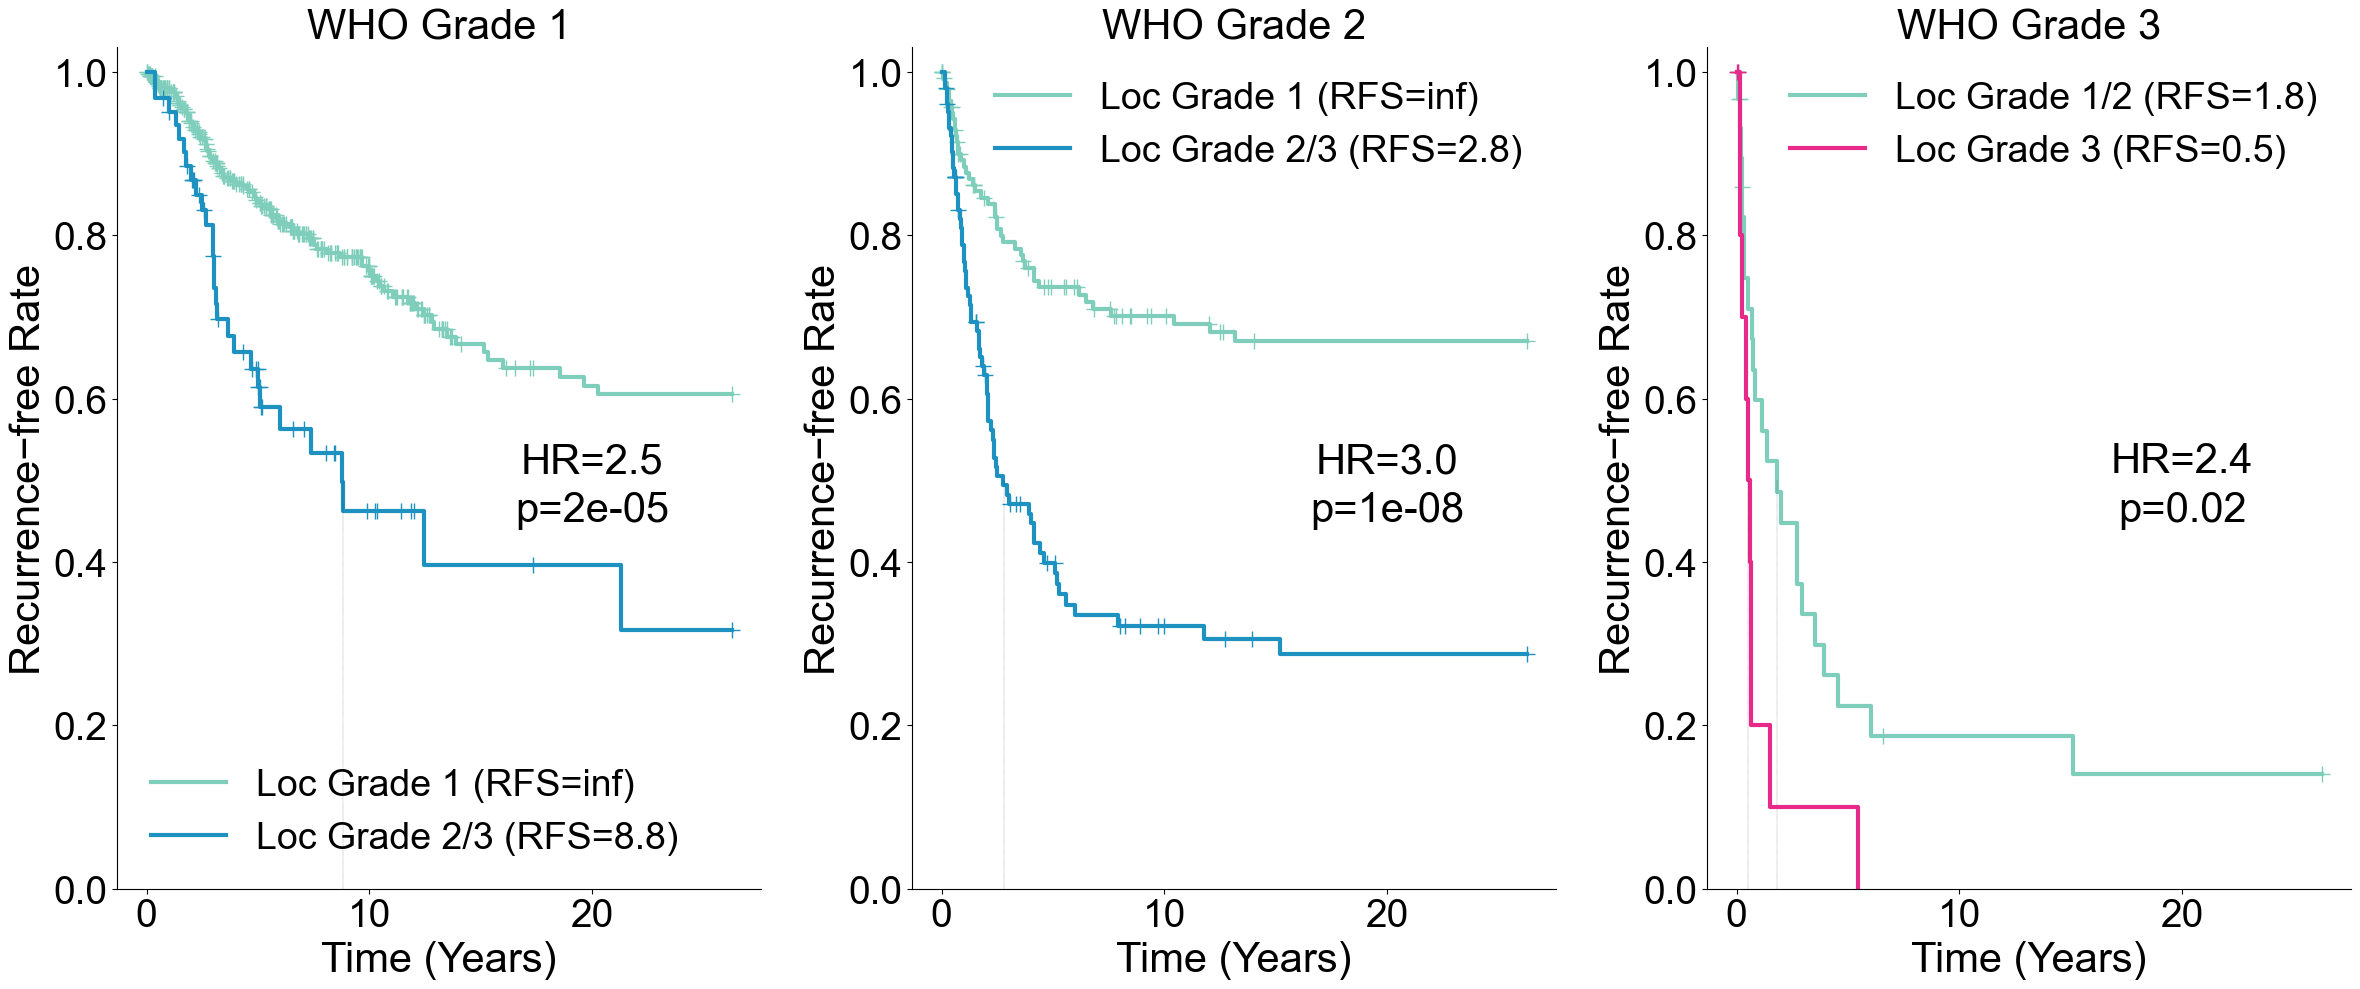

In [20]:
_label_df = (pred_gt_df['GT_WHO_Grade'] + ' -> ' + pred_gt_df['Pred_WHO_Grade']).to_frame(name='label')
kmf_df = pd.concat([metadata_df[['RFS', 'RFS_EVENT']], _label_df], axis=1, join='inner').dropna()

replace_dict_dict = {'WHO I':{'WHO I':'1', 'WHO II':'2/3', 'WHO III':'2/3'},
                     'WHO II':{'WHO I':'1', 'WHO II':'2/3', 'WHO III':'2/3'},
                     'WHO III':{'WHO I':'1/2', 'WHO II':'1/2', 'WHO III':'3'}}

kmf_df['RFS_EVENT'] = kmf_df['RFS_EVENT'].astype(float)
kmf_df['RFS'] = kmf_df['RFS'].astype(float)
kmf_df['RFS'] = kmf_df['RFS']/12

color_dict = {'WHO I':'#7fcdbb', 'WHO II':'#1d91c0', 'WHO III':'#e7298a',
             'WHO 1':'#7fcdbb', 'WHO 2':'#1d91c0', 'WHO 3':'#e7298a', 'WHO 2/3':'#1d91c0', 'WHO 1/2':'#7fcdbb',
             '1':'#7fcdbb', '2':'#1d91c0', '3':'#e7298a', '2/3':'#1d91c0', '1/2':'#7fcdbb'}

idx = pred_gt_df.loc[pred_gt_df.index.isin(SCORE_DF.index)].index.tolist()

pred_gt_df['GT_WHO_Grade']

figsize = (24, 10)
fig, ax = plt.subplots(1,3,figsize=figsize)

title_replace_dict = {'WHO I':'WHO Grade 1', 'WHO II':'WHO Grade 2', 'WHO III':'WHO Grade 3'}

kmf_dict = {}
for i, grade in enumerate(['WHO I', 'WHO II', 'WHO III']):
    
    
    grade_idx = pred_gt_df.loc[pred_gt_df['GT_WHO_Grade'] == grade].index.tolist()
    
    label_df = pred_gt_df['Pred_WHO_Grade'].loc[grade_idx].to_frame(name='label')
    kmf_temp_df = pd.concat([metadata_df[['RFS', 'RFS_EVENT']], label_df], axis=1, join='inner').dropna()
    kmf_temp_df['RFS'] = kmf_temp_df['RFS'].astype(float)/12
    kmf_temp_df['RFS_EVENT'] = kmf_temp_df['RFS_EVENT']
    kmf_temp_df = kmf_temp_df.loc[kmf_temp_df.index.isin(SCORE_DF.index)]
    kmf_temp_df = kmf_temp_df.replace(replace_dict_dict[grade])
    
    # HR
    replace_dict = {'1':0, '2/3':1, '1/2':0, '3':1}
    cph = CoxPHFitter()
    cph.fit(kmf_temp_df.replace(replace_dict), duration_col='RFS', event_col="RFS_EVENT")
    logHR = cph.summary['coef']['label']
    HR = np.round(np.exp(logHR),1)
    
    kmf_dict[grade] = kmf_temp_df
    
    for label in kmf_temp_df['label'].sort_values().unique():
        kmf = KaplanMeierFitter()

        _kmf_df = kmf_temp_df.loc[kmf_temp_df['label'] == label]
        

        kmf.fit(_kmf_df['RFS'], _kmf_df['RFS_EVENT'], label=label)
        median_survival = np.round(kmf.median_survival_time_, 1)
        
        ax[i] = kmf.plot(ax=ax[i], 
                         figsize=figsize, 
                         fontsize=30, 
                         label='Loc Grade ' + label + ' (RFS=' + str(median_survival)+')', 
                         ci_show=False, 
                         color=color_dict[label], 
                         lw=3,
                         show_censors=True)
        ax[i].plot([median_survival,median_survival], [0,0.5], lw=0.25, c='k', ls=':')

    results = multivariate_logrank_test(kmf_temp_df['RFS'].astype(float),  
                                        kmf_temp_df['label'], 
                                        kmf_temp_df['RFS_EVENT'].astype(float))
    p_value = round_pval(results.p_value)
    ax[i].text(x = 20, y=0.51, s='HR='+str(HR), fontsize=30, ha='center')
    ax[i].text(x = 20, y=0.45, s='p='+str(p_value), fontsize=30, ha='center')
    
    ax[i].spines['right'].set_visible(False) 
    ax[i].spines['top'].set_visible(False) 

    ax[i].tick_params(labelsize=28)
    ax[i].set_xlabel('Time (Years)', fontsize=30)
    ax[i].set_ylabel('Recurrence−free Rate', fontsize=30)

    ax[i].legend(fontsize=27, frameon=False)
    ax[i].set_title(title_replace_dict[grade], fontsize=30)

    ax[i].set_ylim(0, 1.03)
    
plt.tight_layout()
# plt.savefig('../figures/nayanga/pdfs/Figure7J.pdf', transparent=True, dpi=300)
plt.show()